# Проект 5. Прогнозирование стоимости автомобиля по характеристикам (Car Price prediction)

## Цель
Создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

## Задачи
1. Собрать данные с внешних источников (см. отдельный Парсер Auto-ru.ipynb);
2. Обработать собранный датасет;
3. Сделать разведовательный анализ данных (EDA);
4. Подобрать наилучшую модель, предсказывающую стоимость автомобиля, а также оптимальные параметры модели.

In [5]:
import pandas as pd
import re
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
            
from IPython.display import Markdown, display
from itertools import combinations
from scipy.stats import ttest_ind

In [231]:
import catboost
from catboost import Pool, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

In [7]:
# VERSION    = 15
# DIR_TRAIN  = '../input/5projectdata' # подключили к ноутбуку внешний датасет
# DIR_TEST   = '../input/5projectdata'
# VAL_SIZE   = 0.20   # 20%

In [8]:
# !ls '../input'

In [9]:
# train_data = pd.read_csv(DIR_TRAIN + '/train_data_equi_dict') # датасет для обучения модели
# test_data = pd.read_csv(DIR_TEST + '/test_car.csv')
# # #sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [10]:
# Для локального запуска
train_data = pd.read_csv('train_car.csv') # датасет для обучения модели
test_data = pd.read_csv('test_car.csv')

In [11]:
pd.set_option('display.max_columns', None)

## ***test_data***

- brand - Брэнд автомобиля
- car_url - Адрес страницы, с которой взята информация
- color - Цвет автомобиля
- complectation_dict - Различные характеристики авто
- description - Описание обьявления на сайте
- engineDisplacement - Объем двигателя
- enginePower - Мощность двигателя
- equipment_dict - Характеристики атомобиля
- fuelType - Тип топлива
- image - Изображение авто
- mileage - Пробег
- modelDate - Год модели
- model_info - Информация о модели авто
- model_name - Модель
- name - Мощности и обьема двигателя
- numberOfDoors - Количество дверей
- parsing_unixtime - Время парсинга
- priceCurrency - Валюта стоимости
- productionDate - Год выпуска
- sell_id - id
- super_gen - Технические характеристики авто
- vehicleConfiguration - Характеристики коробки передач и мощности
- vehicleTransmission - Трансмиссия автомобиля
- vendor - Продавей
- Владельцы - Количество владельцев
- Владение - Время владения
- ПТС - Характеристика ПТС
- Привод - Привод
- Руль - Расположение руля
- Состояние - Состояние авто
- Таможня - Растаможен ли автомобиль

Рассмотрим все колонки данного датафрейма и приведем к нормальному виду

In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [13]:
test_data.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


## bodyType

In [14]:
test_data.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [15]:
def fill_pbodyType(car):
    if car == 'лифтбек':
        return 'LIFTBACK'
    elif car == "внедорожник 5 дв.":
        return 'ALLROAD_5_DOORS'
    elif car == "хэтчбек 5 дв.":
        return 'HATCHBACK_5_DOORS'
    elif car == "седан":
        return 'SEDAN'
    elif car == "компактвэн":
        return 'COMPACTVAN'
    elif car == "универсал 5 дв.":
        return 'WAGON_5_DOORS'
    elif car == "пикап одинарная кабина":
        return 'PICKUP_ONE'
    elif car == "хэтчбек 3 дв.":
        return 'HATCHBACK_3_DOORS'
    elif car == "купе":
        return 'COUPE'
    elif car == "кабриолет":
        return 'CABRIO'
    elif car == "минивэн":
        return 'MINIVAN'
    elif car == "пикап двойная кабина":
        return 'PICKUP_TWO'
    elif car == "внедорожник 3 дв.":
        return 'ALLROAD_3_DOORS'
    elif car == "родстер":
        return 'ROADSTER'
    elif car == "микровэн":
        return 'MICROVAN'
    elif car == "седан 2 дв.":
        return 'SEDAN_2_DOORS'
    elif car == "купе-хардтоп":
        return 'COUPE_HARDTOP'
    elif car == "фастбек":
        return 'FASTBACK'
    elif car == "тарга":
        return 'TARGA'
    elif car == "внедорожник открытый":
        return 'ALLROAD_OPEN'
    elif car == "лимузин":
        return 'LIMOUSINE'
    elif car == "пикап полуторная кабина":
        return 'PICKUP_ONE_HALF'
    elif car == "седан-хардтоп":
        return 'SEDAN_HARDTOP'
    elif car == "фургон":
        return 'VAN'

In [16]:
test_data['bodyType'] = test_data['bodyType'].apply(fill_pbodyType)

In [17]:
test_data.bodyType.unique()

array(['LIFTBACK', 'ALLROAD_5_DOORS', 'HATCHBACK_5_DOORS', 'SEDAN',
       'COMPACTVAN', 'WAGON_5_DOORS', 'PICKUP_ONE', 'HATCHBACK_3_DOORS',
       'COUPE', 'CABRIO', 'MINIVAN', 'PICKUP_TWO', 'ALLROAD_3_DOORS',
       'ROADSTER', 'MICROVAN', 'SEDAN_2_DOORS', 'COUPE_HARDTOP',
       'FASTBACK', 'TARGA', 'ALLROAD_OPEN', 'LIMOUSINE',
       'PICKUP_ONE_HALF', 'SEDAN_HARDTOP', 'VAN'], dtype=object)

## brand

In [18]:
test_data.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

## car_url

In [19]:
test_data.car_url[0]

'https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'

In [20]:
test_data.drop(['car_url'], inplace = True, axis = 1)

## color

In [21]:
test_data.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
      dtype=object)

In [22]:
def fill_color(car):
    if car == 'синий':
        return 'BLUE'
    elif car == "чёрный":
        return 'BLACK'
    elif car == "серый":
        return 'GRAY'
    elif car == "коричневый":
        return 'BROWN'
    elif car == "белый":
        return 'WHITE'
    elif car == "пурпурный":
        return 'MAGENTA'
    elif car == "бежевый":
        return 'BEIGE'
    elif car == "серебристый":
        return 'SILVER'
    elif car == "красный":
        return 'RED'
    elif car == "зелёный":
        return 'GREEN'
    elif car == "жёлтый":
        return 'YELLOW'
    elif car == "голубой":
        return 'LIGHT_BLUE'
    elif car == "оранжевый":
        return 'ORANGE'
    elif car == "фиолетовый":
        return 'PURPLE'
    elif car == "золотистый":
        return 'GOLDEN'
    elif car == "розовый":
        return 'PINK'

In [23]:
test_data['color'] = test_data['color'].apply(fill_color)

In [24]:
test_data.color.unique()

array(['BLUE', 'BLACK', 'GRAY', 'BROWN', 'WHITE', 'MAGENTA', 'BEIGE',
       'SILVER', 'RED', 'GREEN', 'YELLOW', 'LIGHT_BLUE', 'ORANGE',
       'PURPLE', 'GOLDEN', 'PINK'], dtype=object)

## complectation_dict

In [25]:
test_data.complectation_dict

0                                                      NaN
1                                                      NaN
2        {"id":"20026336","name":"Ambition","available_...
3        {"id":"20803582","name":"Ambition","available_...
4                                                      NaN
                               ...                        
34681                                                  NaN
34682                                                  NaN
34683                                                  NaN
34684    {"id":"6336008","name":"xDrive20d Локальная сб...
34685                                                  NaN
Name: complectation_dict, Length: 34686, dtype: object

In [26]:
test_data.drop(['complectation_dict'], inplace = True, axis = 1)

## description

In [27]:
test_data.description[0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

In [28]:
test_data.drop(['description'], inplace = True, axis = 1)

## engineDisplacement

In [29]:
test_data.engineDisplacement.unique() 

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [30]:
test_data[test_data.engineDisplacement == ' LTR']

,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
5241,ALLROAD_5_DOORS,AUDI,WHITE,LTR,408 N12,"{""asr"":true,""esp"":true,""usb"":true,""e-adjustmen...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,885,2018,"{""code"":""E_TRON"",""name"":""e-tron"",""ru_name"":""И-...",E_TRON,55 Electro AT (301 кВт) 4WD,5,1603132719,RUB,2019,1101083243,"{""id"":""22291114"",""name"":""55"",""nameplate"":""55"",...",ALLROAD_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7992,HATCHBACK_5_DOORS,BMW,BLUE,LTR,170 N12,NaN,электро,https://avatars.mds.yandex.net/get-autoru-vos/...,32000,2017,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603109407,RUB,2018,1101043134,"{""id"":""21624534"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8252,HATCHBACK_5_DOORS,BMW,GRAY,LTR,170 N12,"{""park-assist-f"":true,""park-assist-r"":true}",электро,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,51000,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603110423,RUB,2014,1101278018,"{""id"":""20465813"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8350,HATCHBACK_5_DOORS,BMW,WHITE,LTR,170 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,25000,2017,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603110814,RUB,2018,1100271628,"{""id"":""21624534"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8684,HATCHBACK_5_DOORS,BMW,BLACK,LTR,170 N12,"{""cruise-control"":true,""glonass"":true,""navigat...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,58500,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,94Ah Electro AT (126 кВт),5,1603112107,RUB,2017,1101174554,"{""id"":""20789143"",""nameplate"":""94Ah"",""displacem...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8722,HATCHBACK_5_DOORS,BMW,LIGHT_BLUE,LTR,170 N12,NaN,электро,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,28800,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603112248,RUB,2017,1100097316,"{""id"":""20465813"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8917,HATCHBACK_5_DOORS,BMW,BEIGE,LTR,170 N12,"{""glonass"":true,""roof-rails"":true}",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,39000,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,94Ah Electro AT (126 кВт),5,1603113092,RUB,2017,1100871574,"{""id"":""20789143"",""nameplate"":""94Ah"",""displacem...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10817,HATCHBACK_5_DOORS,BMW,GRAY,LTR,170 N12,NaN,электро,https://avatars.mds.yandex.net/get-autoru-vos/...,50359,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603120595,RUB,2016,1101266443,"{""id"":""20465813"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10936,HATCHBACK_5_DOORS,BMW,BLACK,LTR,170 N12,"{""cruise-con

In [31]:
test_data[test_data.engineDisplacement == ' LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [32]:
test_data.loc[test_data['engineDisplacement'] == ' LTR','engineDisplacement'] = '0 LTR'

In [33]:
def V_engine(cell):
    V = cell.find('LTR')
    return(float(cell[:V]))

In [34]:
test_data.engineDisplacement = test_data.engineDisplacement.apply(V_engine)

In [35]:
test_data.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7])

## enginePower 

In [36]:
test_data.enginePower.unique()   

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [37]:
def power_engine(car):
    pattern = re.compile('[0-9.]+')
    if pattern.match(car):
        eng_disp = re.findall(pattern, car)
        return int(eng_disp[0])
    else:
        return 0

In [38]:
test_data.enginePower = test_data.enginePower.apply(power_engine)

In [39]:
test_data.enginePower.unique()[:10]

array([105, 110, 152, 200, 102, 150,  90, 180, 220, 122])

## equipment_dict

In [40]:
type(test_data.equipment_dict[222])

str

In [41]:
test_data['equipment_dict'].isna().value_counts()

False    24690
True      9996
Name: equipment_dict, dtype: int64

In [42]:
test_data['equipment_dict'][77]

'{"engine-proof":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"aux":true,"usb":true,"isofix":true,"electro-window-front":true,"multi-wheel":true,"hcc":true,"audiosystem-tv":true,"heated-wash-system":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"front-centre-armrest":true,"computer":true,"apple-carplay":true,"roof-rails":true,"seat-transformation":true,"wheel-power":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"electro-window-back":true,"alloy-wheel-disks":true,"ptf":true,"rain-sensor":true,"airbag-side":true,"mirrors-heat":true,"17-inch-wheels":true,"park-assist-f":true,"audiosystem-cd":true,"cooling-box":true,"abs":true,"bluetooth":true,"front-seats-heat":true,"wheel-leather":true,"wheel-configuration2":true,"wheel-configuration1":true,"immo":true,"220v-socket":true,"climate-control-2":true,"12v-socket":true,"park-assist-r":true}'

In [43]:
test_data.drop(['equipment_dict'], axis = 1, inplace = True)

## image

In [44]:
test_data['image'].loc[0]

'https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxu9oaUHn7ahNSrqiKwm-CQDyDolDeEoEc3J49fgWYNYBUbQC7D96sj6K9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD'

In [45]:
test_data.drop(['image'], axis = 1, inplace = True)

## mileage

In [46]:
test_data['mileage'].isnull().sum()

0

In [47]:
test_data['mileage'].loc[0]

74000

## modelDate

In [48]:
test_data['modelDate'].loc[0]

2013

In [49]:
type(test_data['modelDate'].loc[0])

numpy.int64

## model_info

In [50]:
test_data['model_info'].loc[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [51]:
test_data.drop(['model_info'], axis = 1, inplace = True)

## model_name

In [52]:
test_data['model_name'].loc[0]

'OCTAVIA'

In [53]:
test_data['model_name'].nunique()

544

## name

In [54]:
test_data['name'].loc[0]

'1.2 AMT (105 л.с.)'

In [55]:
test_data.drop(['name'], axis = 1, inplace = True)

## numberOfDoors

In [56]:
test_data['numberOfDoors'].unique()

array([5, 4, 2, 3, 0])

In [57]:
type(test_data['numberOfDoors'].loc[0])

numpy.int64

## parsing_unixtime

In [58]:
test_data['parsing_unixtime'].loc[0]

1603226273

In [59]:
test_data.drop(['parsing_unixtime'], axis = 1, inplace = True)

## priceCurrency

In [60]:
test_data['priceCurrency'].loc[0]

'RUB'

In [61]:
test_data.drop(['priceCurrency'], axis = 1, inplace = True)

## productionDate

In [62]:
test_data['productionDate'].loc[0]

2014

In [63]:
type(test_data['productionDate'].loc[0])

numpy.int64

## sell_id

In [64]:
test_data['sell_id'].loc[0]

1100575026

## super_gen

In [65]:
#Переведем данные в ячейках в формат словаря

#На основе данных создадим 6 новых столбцов

In [66]:
test_data['super_gen'] = test_data['super_gen'].apply(literal_eval)

In [67]:
test_data['super_gen'].loc[0]

{'id': '10373605',
 'displacement': 1197,
 'engine_type': 'GASOLINE',
 'gear_type': 'FORWARD_CONTROL',
 'transmission': 'ROBOT',
 'power': 105,
 'power_kvt': 77,
 'human_name': '1.2 AMT (105 л.с.)',
 'acceleration': 10.5,
 'clearance_min': 155,
 'fuel_rate': 5}

In [68]:
test_data['acceleration'] = test_data['super_gen'].apply(lambda x: x.get('acceleration'))

In [69]:
test_data['clearance_min'] = test_data['super_gen'].apply(lambda x: x.get('clearance_min'))

In [70]:
test_data['fuel_rate'] = test_data['super_gen'].apply(lambda x: x.get('fuel_rate'))

In [71]:
test_data['gearType'] = test_data['super_gen'].apply(lambda x: x.get('gear_type'))

In [72]:
test_data['fuelType'] = test_data['super_gen'].apply(lambda x: x.get('engine_type'))

In [73]:
test_data['transmission'] = test_data['super_gen'].apply(lambda x: x.get('transmission'))

Удалим повторяющиеся

In [74]:
# Столбец 'Привод' идентичен 'gear_type'

In [75]:
test_data.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'acceleration',
       'clearance_min', 'fuel_rate', 'gearType', 'transmission'],
      dtype='object')

In [76]:
test_data['Привод'].unique()

array(['передний', 'полный', 'задний'], dtype=object)

In [77]:
test_data['gearType'].unique()

array(['FORWARD_CONTROL', 'ALL_WHEEL_DRIVE', 'REAR_DRIVE'], dtype=object)

In [78]:
test_data.drop(['Привод'], axis = 1, inplace = True)

In [79]:
# Столбец 'vehicleTransmission' идентичен 'transmission'

In [80]:
test_data['vehicleTransmission'].unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [81]:
test_data['transmission'].unique()

array(['ROBOT', 'MECHANICAL', 'AUTOMATIC', 'VARIATOR'], dtype=object)

In [82]:
test_data.drop(['vehicleTransmission'], axis = 1, inplace = True)

In [83]:
test_data['fuelType'].unique()

array(['GASOLINE', 'DIESEL', 'HYBRID', 'ELECTRO', 'LPG'], dtype=object)

In [84]:
# и удаляем сам столбец super_gen, он нам больше не нужен

In [85]:
test_data.drop(['super_gen'], axis = 1, inplace = True)

In [86]:
test_data.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'sell_id', 'vehicleConfiguration', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Руль', 'Состояние', 'Таможня',
       'acceleration', 'clearance_min', 'fuel_rate', 'gearType',
       'transmission'],
      dtype='object')

In [87]:
test_data.head(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vendor,Владельцы,Владение,ПТС,Руль,Состояние,Таможня,acceleration,clearance_min,fuel_rate,gearType,transmission
0,LIFTBACK,SKODA,BLUE,1.2,105,GASOLINE,74000,2013,OCTAVIA,5,2014,1100575026,LIFTBACK ROBOT 1.2,EUROPEAN,3 или более,NaN,Оригинал,Левый,Не требует ремонта,Растаможен,10.5,155.0,5.0,FORWARD_CONTROL,ROBOT
1,LIFTBACK,SKODA,BLACK,1.6,110,GASOLINE,60563,2017,OCTAVIA,5,2017,1100549428,LIFTBACK MECHANICAL 1.6,EUROPEAN,1 владелец,NaN,Оригинал,Левый,Не требует ремонта,Растаможен,10.8,156.0,6.4,FORWARD_CONTROL,MECHANICAL
2,LIFTBACK,SKODA,GRAY,1.8,152,GASOLINE,88000,2013,SUPERB,5,2014,1100658222,LIFTBACK ROBOT 1.8,EUROPEAN,1 владелец,NaN,Оригинал,Левый,Не требует ремонта,Растаможен,8.7,139.0,7.1,FORWARD_CONTROL,ROBOT
3,LIFTBACK,SKODA,BROWN,1.6,110,GASOLINE,95000,2013,OCTAVIA,5,2014,1100937408,LIFTBACK AUTOMATIC 1.6,EUROPEAN,1 владелец,NaN,Оригинал,Левый,Не требует ремонта,Растаможен,12.2,155.0,6.7,FORWARD_CONTROL,AUTOMATIC
4,LIFTBACK,SKODA,WHITE,1.8,152,GASOLINE,58536,2008,OCTAVIA,5,2012,1101037972,LIFTBACK AUTOMATIC 1.8,EUROPEAN,1 владелец,NaN,Оригинал,Левый,Не требует ремонта,Растаможен,8.8,164.0,7.7,FORWARD_CONTROL,AUTOMATIC


## vehicleConfiguration

In [88]:
test_data['vehicleConfiguration'].loc[0]

'LIFTBACK ROBOT 1.2'

In [89]:
test_data['vehicleConfiguration'].unique()[:10]

array(['LIFTBACK ROBOT 1.2', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK ROBOT 1.8', 'LIFTBACK AUTOMATIC 1.6',
       'LIFTBACK AUTOMATIC 1.8', 'LIFTBACK ROBOT 2.0',
       'ALLROAD_5_DOORS ROBOT 1.8', 'ALLROAD_5_DOORS MECHANICAL 1.4',
       'ALLROAD_5_DOORS MECHANICAL 1.8', 'LIFTBACK ROBOT 1.4'],
      dtype=object)

In [90]:
test_data.drop(['vehicleConfiguration'], axis = 1, inplace = True)

## vendor

In [91]:
test_data['vendor'].unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

## Владельцы

In [92]:
test_data['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [93]:
def fill_owners(car):
    if car == '3 или более':
        return 3
    elif car == '1\xa0владелец':
        return 1
    elif car == '2\xa0владельца':
        return 2

In [94]:
test_data['owners_number'] = test_data['Владельцы'].apply(fill_owners)

In [95]:
test_data.drop(['Владельцы'], inplace = True, axis = 1)

## Владение

In [96]:
test_data['Владение'].unique()[:10]

array([nan, '3 года и 2 месяца', '11 месяцев', '4 года и 1 месяц',
       '2 года и 4 месяца', '1 месяц', '3 года и 10 месяцев',
       '2 года и 6 месяцев', '6 лет и 4 месяца', '2 месяца'], dtype=object)

In [97]:
test_data['Владение'].isnull().sum()

22691

In [98]:
test_data.drop(['Владение'], inplace = True, axis = 1)

## ПТС

In [99]:
test_data['ПТС'].unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [100]:
test_data['ПТС'].isnull().sum()

1

In [101]:
test_data['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [102]:
test_data['ПТС'] = test_data['ПТС'].fillna('Оригинал') 

In [103]:
def fill_registration(car):
    if car == 'Оригинал':
        return 1
    elif car == 'Дубликат':
        return 0

In [104]:
test_data['original_registration'] = test_data['ПТС'].apply(fill_registration)

In [105]:
test_data.drop(['ПТС'], inplace = True, axis = 1)

## Руль

In [106]:
test_data['Руль'].unique()

array(['Левый', 'Правый'], dtype=object)

In [107]:
def fill_steering_wheel(car):
    if car == 'Левый':
        return 'LEFT'
    elif car == 'Правый':
        return 'RIGHT'

In [108]:
test_data['steering_wheel'] = test_data['Руль'].apply(fill_steering_wheel)

In [109]:
test_data.drop(['Руль'], inplace = True, axis = 1)

## Состояние

In [110]:
test_data['Состояние'].unique()

array(['Не требует ремонта'], dtype=object)

In [111]:
test_data.drop(['Состояние'], inplace = True, axis = 1)

## Таможня

In [112]:
test_data['Таможня'].unique()

array(['Растаможен'], dtype=object)

In [113]:
test_data.drop(['Таможня'], inplace = True, axis = 1)

In [114]:
test_data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vendor,acceleration,clearance_min,fuel_rate,gearType,transmission,owners_number,original_registration,steering_wheel
0,LIFTBACK,SKODA,BLUE,1.2,105,GASOLINE,74000,2013,OCTAVIA,5,2014,1100575026,EUROPEAN,10.5,155.0,5.0,FORWARD_CONTROL,ROBOT,3,1,LEFT
1,LIFTBACK,SKODA,BLACK,1.6,110,GASOLINE,60563,2017,OCTAVIA,5,2017,1100549428,EUROPEAN,10.8,156.0,6.4,FORWARD_CONTROL,MECHANICAL,1,1,LEFT
2,LIFTBACK,SKODA,GRAY,1.8,152,GASOLINE,88000,2013,SUPERB,5,2014,1100658222,EUROPEAN,8.7,139.0,7.1,FORWARD_CONTROL,ROBOT,1,1,LEFT
3,LIFTBACK,SKODA,BROWN,1.6,110,GASOLINE,95000,2013,OCTAVIA,5,2014,1100937408,EUROPEAN,12.2,155.0,6.7,FORWARD_CONTROL,AUTOMATIC,1,1,LEFT
4,LIFTBACK,SKODA,WHITE,1.8,152,GASOLINE,58536,2008,OCTAVIA,5,2012,1101037972,EUROPEAN,8.8,164.0,7.7,FORWARD_CONTROL,AUTOMATIC,1,1,LEFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,SEDAN,BMW,BROWN,1.6,136,GASOLINE,115000,2011,3ER,4,2014,1101369263,EUROPEAN,9.2,140.0,5.8,REAR_DRIVE,AUTOMATIC,3,1,LEFT
34682,SEDAN,BMW,BLACK,2.0,190,DIESEL,98000,2016,5ER,4,2018,1101369581,EUROPEAN,7.6,139.0,4.9,ALL_WHEEL_DRIVE,AUTOMATIC,1,1,LEFT
34683,SEDAN,BMW,GRAY,2.5,170,GASOLINE,360000,1995,5ER,4,1997,1101364889,EUROPEAN,9.6,120.0,10.3,REAR_DRIVE,AUTOMATIC,3,0,LEFT
34684,ALLROAD_5_DOORS,BMW,BROWN,2.0,184,DIESEL,90500,2012,X1,5,2013,1101362518,EUROPEAN,8.1,195.0,5.4,ALL_WHEEL_DRIVE,AUTOMATIC,2,1,LEFT


## ***Train_data***

In [115]:
train_data

,bodyType,brand,model_name,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,transmission,vendor,acceleration,clearance_min,fuel_rate,owners_number,original_registration,gearType,steering_wheel,price,equipment_dict
0,ALLROAD_5_DOORS,BMW,X5,040001,4619,347,GASOLINE,151151,1999,5,2003,1102994615,AUTOMATIC,EUROPEAN,6.5,180,14.9,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1188000,0
1,ALLROAD_5_DOORS,BMW,X5,040001,2993,218,DIESEL,480000,2003,5,2004,1105975644,AUTOMATIC,EUROPEAN,8.8,203,9.4,2,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,855000,16
2,ALLROAD_5_DOORS,BMW,X5,97948F,2979,231,GASOLINE,303000,1999,5,2002,1105070288,AUTOMATIC,EUROPEAN,8.8,180,12.9,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,720000,1
3,SEDAN,BMW,5ER,0000CC,2494,192,GASOLINE,315000,2000,4,2003,1105561887,MECHANICAL,EUROPEAN,8.1,120,9.4,4,DUPLICATE,REAR_DRIVE,LEFT,200000,24
4,SEDAN,BMW,5ER,007F00,2494,192,GASOLINE,302543,2000,4,2002,1105068025,AUTOMATIC,EUROPEAN,8.9,120,10.3,3,DUPLICATE,REAR_DRIVE,LEFT,395000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32199,SEDAN,AUDI,100,660099,2309,136,GASOLINE,300000,1988,4,1988,1105529448,AUTOMATIC,EUROPEAN,11.5,133,9.399999618530273,4,ORIGINAL,FORWARD_CONTROL,LEFT,200000,1
32200,SEDAN,AUDI,80,4A2197,1781,90,GASOLINE,190000,1986,4,1989,1079718966,AUTOMATIC,EUROPEAN,14.699999809265137,130,8.5,3,DUPLICATE,FORWARD_CONTROL,LEFT,65000,1
32201,SEDAN,AUDI,80,EE1D19,1781,90,GASOLINE,300000,1986,4,1988,1106020207,MECHANICAL,EUROPEAN,12.399999618530273,130,7.599999904632568,3,DUPLICATE,FORWARD_CONTROL,LEFT,85000,0
32202,SEDAN,AUDI,80,007F00,1595,75,GASOLINE,150000,1978,4,1984,1105399269,MECHANICAL,EUROPEAN,14.100000381469727,130,8.300000190734863,2,ORIGINAL,FORWARD_CONTROL,LEFT,42000,1


In [116]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32204 entries, 0 to 32203
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   bodyType               32204 non-null  object
 1   brand                  32204 non-null  object
 2   model_name             32204 non-null  object
 3   color                  32204 non-null  object
 4   engineDisplacement     32204 non-null  int64 
 5   enginePower            32204 non-null  int64 
 6   fuelType               32204 non-null  object
 7   mileage                32204 non-null  int64 
 8   modelDate              32204 non-null  int64 
 9   numberOfDoors          32204 non-null  int64 
 10  productionDate         32204 non-null  int64 
 11  sell_id                32204 non-null  int64 
 12  transmission           32204 non-null  object
 13  vendor                 32204 non-null  object
 14  acceleration           32204 non-null  object
 15  clearance_min      

## color

In [117]:
train_data['color'].value_counts()

040001    10144
FAFBFB     6403
97948F     4184
0000CC     3199
CACECB     3002
200204     1415
EE1D19     1401
007F00      761
C49648      510
22A0F8      275
660099      239
FFD600      192
4A2197      188
DEA522      151
FF8649      131
FFC0CB        9
Name: color, dtype: int64

In [118]:
def fill_color(car):
    if car == '0000CC':
        return 'BLUE'
    elif car == "040001":
        return 'BLACK'
    elif car == "200204":
        return 'BLACK'
    elif car == "97948F":
        return 'GRAY'
    elif car == "FAFBFB":
        return 'WHITE'
    elif car == "CACECB":
        return 'SILVER'
    elif car == "EE1D19":
        return 'RED'
    elif car == "007F00":
        return 'GREEN'
    elif car == "FFD600":
        return 'YELLOW'
    elif car == "22A0F8":
        return 'LIGHT_BLUE'
    elif car == "FF8649":
        return 'ORANGE'
    elif car == "660099":
        return 'PURPLE'
    elif car == "4A2197":
        return 'PURPLE'
    elif car == "C49648":
        return 'GOLDEN'
    elif car == "DEA522":
        return 'GOLDEN'
    elif car == "FFC0CB":
        return 'PINK'

In [119]:
train_data['color'] = train_data['color'].apply(fill_color)

In [120]:
train_data['color'].unique()

array(['BLACK', 'GRAY', 'BLUE', 'GREEN', 'PURPLE', 'SILVER', 'WHITE',
       'RED', 'LIGHT_BLUE', 'GOLDEN', 'YELLOW', 'ORANGE', 'PINK'],
      dtype=object)

## engineDisplacement

In [121]:
train_data['engineDisplacement'].unique()[:10]

array([4619, 2993, 2979, 2494, 1991, 2793, 2491, 4398, 1895, 5972])

In [122]:
train_data['engineDisplacement'] = train_data['engineDisplacement'].apply(lambda x : round((x/1000),1))

In [123]:
train_data['engineDisplacement'].unique()[:10]

array([4.6, 3. , 2.5, 2. , 2.8, 4.4, 1.9, 6. , 2.2, 2.9])

## enginePower

In [124]:
train_data['enginePower'].unique()[:10]

array([347, 218, 231, 192, 170, 150, 193, 333, 286, 118])

## acceleration

In [125]:
train_data['acceleration'].isnull().sum()

0

In [126]:
train_data['acceleration'].unique()

array(['6.5', '8.8', '8.1', '8.9', '8.5', '11.7', '10.6', '10.2', '6.3',
       '7.5', '11.5', '10.4', '5.5', '9.6', '8.6', '9', '7.9', '8.3',
       '10.5', '9.5', '10.8', '6.6', '7.6', '9.1', '12.3', '13.9', '7',
       '8', '13.6', '12.2', '7.4', '9.3', '6.4', '5.6', '6.9', '10.1',
       '7.1', '11.3', '12.4', '5.3', '6.7', '11.1', '12.7', '8.2', '9.9',
       '5.2', '10', '6.1', '7.8', '7.7', '11.9', '8.4', '9.8', '6.8',
       '7.2', '5.4', '4.7', '9.7', '9.2', '5.9', '8.7', '7.3', '11',
       '12.8', '5.8', '5.1', '5.7', '4.9', '4.6', '6', '4.4', '4.8',
       '6.2', '4.2', '5', '9.4', '11.2', '3.9', '3.3', '3.8', '4', '4.1',
       '10.9', '4.5', '4.3', '3.4', '3.2', '13.5', '3.7', '14', '11.6',
       '14.2', '15.6', '13.1', '12', '12.1', '15', '21.7', '19.5', '16.3',
       '19.1', '16', '15.3', '12.9', '13.7', '14.4', '10.3', '17.7',
       '15.9', '16.4', '13.3', '17', '11.8', '16.5', '15.2', '24.7',
       '18.8', 'None', '12.5', '18.1', '20.5', '15.4', '14.7', '14.9',
  

In [127]:
train_data.loc[train_data['acceleration'] == 'None','acceleration'] = '10.0'

In [128]:
train_data['acceleration'] = train_data['acceleration'].astype(float) 

In [129]:
train_data['acceleration'] = train_data['acceleration'].apply(lambda x : round((x),1))

In [130]:
train_data['acceleration'].unique()[:10]

array([ 6.5,  8.8,  8.1,  8.9,  8.5, 11.7, 10.6, 10.2,  6.3,  7.5])

## clearance_min

In [131]:
train_data['clearance_min'].unique()

array(['180', '203', '120', '130', '125', '110', '200', '140', '145',
       '144', '142', '143', '212', '222', '151', '195', '148', '201',
       '141', '138', '124', '132', '117', '126', '152', '123', '107',
       '165', '147', '108', '114', '209', '149', '131', '179', '139',
       '221', '135', '133', '118', '128', '204', '214', '213', '136',
       '183', '121', '156', '216', '155', '182', '150', '170', '237',
       '109', '160', '104', '300', '119', '193', '176', '127', '98',
       '186', '192', '154', '249', '146', '159', '115', '137', '91',
       '106', '163', '202', '158', '191', '174', '178', '189', '166',
       'None', '175', '220', '210', '250', '238', '105', '240', '230',
       '228', '233', '274', '226', '215', '259', '205', '184', '181',
       '185', '211', '217', '276', '99', '97', '266', '196', '122', '93',
       '206', '198', '241', '112', '235', '438', '95', '94', '134', '162',
       '89', '231', '275', '420', '225', '197', '254', '190', '260',
       '168',

In [132]:
train_data.loc[train_data['clearance_min'] == 'None','clearance_min'] = '200'

In [133]:
train_data['clearance_min'] = train_data['clearance_min'].astype(int) 

## fuel_rate

In [134]:
train_data['fuel_rate'].unique()

array(['14.9', '9.4', '12.9', '10.3', '9.7', '9', '10.1', '8.9', '10.7',
       '10.9', '13.9', '9.9', 'None', '13.4', '9.5', '9.1', '8.2', '8.6',
       '14.2', '8.1', '12.1', '7.7', '7.2', '13.1', '8.3', '11.5', '11.7',
       '9.6', '7.3', '7.8', '7.6', '11.4', '12.5', '13', '12.4', '7.4',
       '14', '12', '6.7', '8.8', '13.6', '9.8', '11.1', '13.5', '8.4',
       '11.2', '8', '10.4', '11.9', '10', '9.3', '12.7', '14.4', '7.9',
       '10.2', '10.6', '12.8', '10.8', '5.9', '8.5', '12.2', '8.7', '7.5',
       '11', '6.9', '5.6', '6.3', '9.2', '7', '6.4', '10.5', '6.5', '5.8',
       '5.7', '5.2', '6', '6.2', '4.4', '4.7', '7.1', '5.4', '5.3', '5.5',
       '4.6', '6.1', '11.3', '13.8', '6.8', '6.6', '4.5', '12.3', '14.8',
       '5.1', '4.8', '11.8', '5', '0.6', '4.3', '4.9', '0.7', '4', '4.1',
       '4.2', '2.1', '11.6', '1.9', '3', '14.7', '15.7', '13.3', '14.5',
       '1.6', '15.5', '14.3', '16.3', '18.2', '16.7', '3.8', '3.9', '2.7',
       '3.3', '14.1', '15.6', '15.4', '15.

In [135]:
train_data.loc[train_data['fuel_rate'] == 'None','fuel_rate'] = '10.0'

In [136]:
train_data['fuel_rate'] = train_data['fuel_rate'].astype(float) 

In [137]:
train_data['fuel_rate'] = train_data['fuel_rate'].apply(lambda x : round((x),1))

## owners_number

In [138]:
train_data['owners_number'].unique()

array(['3', '2', '4', '1', 'None'], dtype=object)

In [139]:
train_data.loc[train_data['owners_number'] == 'None','owners_number'] = '2'

In [140]:
train_data['owners_number'] = train_data['owners_number'].astype(int) 

## gearType

In [141]:
train_data['gearType'].value_counts()

ALL_WHEEL_DRIVE    15526
FORWARD_CONTROL    12502
REAR_DRIVE          4176
Name: gearType, dtype: int64

## original_registration

In [142]:
train_data['original_registration'].value_counts()

ORIGINAL     27540
DUPLICATE     4660
None             4
Name: original_registration, dtype: int64

In [143]:
train_data.loc[train_data['original_registration'] == 'None','original_registration'] = 'ORIGINAL'

In [144]:
def fill_registration(car):
    if car == 'ORIGINAL':
        return 1
    elif car == 'DUPLICATE':
        return 0

In [145]:
train_data['original_registration'] = train_data['original_registration'].apply(fill_registration) 

## train_data['price']

In [146]:
train_data['price'].isnull().sum()


0

In [147]:
train_data['price'].value_counts()


1200000    305
650000     260
1250000    257
550000     247
1100000    243
          ... 
3429000      1
1386000      1
4659000      1
1855000      1
3595000      1
Name: price, Length: 4124, dtype: int64

In [148]:
train_data[train_data['price'] == 'None']


,bodyType,brand,model_name,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,transmission,vendor,acceleration,clearance_min,fuel_rate,owners_number,original_registration,gearType,steering_wheel,price,equipment_dict
20,SEDAN,BMW,3ER,GRAY,2.5,170,GASOLINE,152000,1990,4,1997,1105987730,AUTOMATIC,EUROPEAN,9.0,130,10.1,3,1,REAR_DRIVE,LEFT,None,1
52,SEDAN,BMW,5ER,BLACK,2.5,192,GASOLINE,348000,2000,4,2002,1105775868,AUTOMATIC,EUROPEAN,8.9,120,10.3,3,1,REAR_DRIVE,LEFT,None,1
82,SEDAN,BMW,5ER,BLUE,2.0,150,GASOLINE,425000,1987,4,1991,1106007928,MECHANICAL,EUROPEAN,10.6,120,8.9,3,0,REAR_DRIVE,LEFT,None,1
594,ALLROAD_5_DOORS,BMW,X6,PURPLE,3.0,245,DIESEL,167000,2012,5,2013,1106003674,AUTOMATIC,EUROPEAN,7.5,212,7.4,2,1,ALL_WHEEL_DRIVE,LEFT,None,1
626,SEDAN,BMW,5ER,WHITE,3.0,258,GASOLINE,222000,2009,4,2010,1105954456,AUTOMATIC,EUROPEAN,6.7,141,8.0,4,1,REAR_DRIVE,LEFT,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30655,ALLROAD_5_DOORS,VOLVO,XC90,BLACK,2.4,185,DIESEL,299300,2006,5,2008,1106012461,AUTOMATIC,EUROPEAN,11.5,220,9.0,2,1,ALL_WHEEL_DRIVE,LEFT,None,0
30689,SEDAN,VOLVO,S40,BLACK,2.4,140,GASOLINE,174000,2007,4,2008,1106013206,AUTOMATIC,EUROPEAN,10.5,141,9.1,4,1,FORWARD_CONTROL,LEFT,None,1
31690,SEDAN,TOYOTA,MARK_II,WHITE,2.0,135,GASOLINE,200000,1988,4,1990,1105994433,AUTOMATIC,JAPANESE,12.3,155,10.7,4,1,REAR_DRIVE,RIGHT,None,1
31725,WAGON_5_DOORS,VOLKSWAGEN,PASSAT,BLUE,2.0,136,GASOLINE,3000,1988,5,1989,1106002284,MECHANICAL,EUROPEAN,10.4,150,8.1,3,1,FORWARD_CONTROL,LEFT,None,1


In [149]:
train_data.drop(train_data[train_data['price'] == 'None'].index, inplace =True)

In [150]:
train_data['price'] = train_data['price'].astype(int)

In [151]:
# скоректируем цену с поправкой на подорожание машин за 2 года
# данная цифра была выбрана опытным путем как оптимально отражающая изменение стоимости

In [152]:
train_data['price'] = train_data['price'].apply(lambda x: int(x/1.3))

## model_name

In [153]:
train_data['model_name'].nunique()

538

## equipment_dict

In [154]:

train_data.drop(['equipment_dict'], axis = 1, inplace = True)

# *Обьединение датасетов*

In [155]:
test_data.shape

(34686, 21)

In [156]:
test_data.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'sell_id', 'vendor', 'acceleration', 'clearance_min',
       'fuel_rate', 'gearType', 'transmission', 'owners_number',
       'original_registration', 'steering_wheel'],
      dtype='object')

In [157]:
train_data.shape

(32121, 22)

In [158]:
train_data.columns

Index(['bodyType', 'brand', 'model_name', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'numberOfDoors',
       'productionDate', 'sell_id', 'transmission', 'vendor', 'acceleration',
       'clearance_min', 'fuel_rate', 'owners_number', 'original_registration',
       'gearType', 'steering_wheel', 'price'],
      dtype='object')

In [159]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train_data['sample'] = 1 # помечаем где у нас трейн
test_data['sample'] = 0 # помечаем где у нас тест
test_data['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями


In [160]:
data = test_data.append(train_data, sort=False).reset_index(drop=True) # объединяем

In [161]:
data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vendor,acceleration,clearance_min,fuel_rate,gearType,transmission,owners_number,original_registration,steering_wheel,sample,price
0,LIFTBACK,SKODA,BLUE,1.2,105,GASOLINE,74000,2013,OCTAVIA,5,2014,1100575026,EUROPEAN,10.5,155.0,5.0,FORWARD_CONTROL,ROBOT,3,1,LEFT,0,0
1,LIFTBACK,SKODA,BLACK,1.6,110,GASOLINE,60563,2017,OCTAVIA,5,2017,1100549428,EUROPEAN,10.8,156.0,6.4,FORWARD_CONTROL,MECHANICAL,1,1,LEFT,0,0
2,LIFTBACK,SKODA,GRAY,1.8,152,GASOLINE,88000,2013,SUPERB,5,2014,1100658222,EUROPEAN,8.7,139.0,7.1,FORWARD_CONTROL,ROBOT,1,1,LEFT,0,0
3,LIFTBACK,SKODA,BROWN,1.6,110,GASOLINE,95000,2013,OCTAVIA,5,2014,1100937408,EUROPEAN,12.2,155.0,6.7,FORWARD_CONTROL,AUTOMATIC,1,1,LEFT,0,0
4,LIFTBACK,SKODA,WHITE,1.8,152,GASOLINE,58536,2008,OCTAVIA,5,2012,1101037972,EUROPEAN,8.8,164.0,7.7,FORWARD_CONTROL,AUTOMATIC,1,1,LEFT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66802,SEDAN,AUDI,PURPLE,2.3,136,GASOLINE,300000,1988,100,4,1988,1105529448,EUROPEAN,11.5,133.0,9.4,FORWARD_CONTROL,AUTOMATIC,4,1,LEFT,1,153846
66803,SEDAN,AUDI,PURPLE,1.8,90,GASOLINE,190000,1986,80,4,1989,1079718966,EUROPEAN,14.7,130.0,8.5,FORWARD_CONTROL,AUTOMATIC,3,0,LEFT,1,50000
66804,SEDAN,AUDI,RED,1.8,90,GASOLINE,300000,1986,80,4,1988,1106020207,EUROPEAN,12.4,130.0,7.6,FORWARD_CONTROL,MECHANICAL,3,0,LEFT,1,65384
66805,SEDAN,AUDI,GREEN,1.6,75,GASOLINE,150000,1978,80,4,1984,1105399269,EUROPEAN,14.1,130.0,8.3,FORWARD_CONTROL,MECHANICAL,2,1,LEFT,1,32307


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               66807 non-null  object 
 1   brand                  66807 non-null  object 
 2   color                  66807 non-null  object 
 3   engineDisplacement     66807 non-null  float64
 4   enginePower            66807 non-null  int64  
 5   fuelType               66807 non-null  object 
 6   mileage                66807 non-null  int64  
 7   modelDate              66807 non-null  int64  
 8   model_name             66807 non-null  object 
 9   numberOfDoors          66807 non-null  int64  
 10  productionDate         66807 non-null  int64  
 11  sell_id                66807 non-null  int64  
 12  vendor                 66807 non-null  object 
 13  acceleration           64862 non-null  float64
 14  clearance_min          65856 non-null  float64
 15  fu

## data['bodyType']

In [163]:
data['bodyType'].unique()

array(['LIFTBACK', 'ALLROAD_5_DOORS', 'HATCHBACK_5_DOORS', 'SEDAN',
       'COMPACTVAN', 'WAGON_5_DOORS', 'PICKUP_ONE', 'HATCHBACK_3_DOORS',
       'COUPE', 'CABRIO', 'MINIVAN', 'PICKUP_TWO', 'ALLROAD_3_DOORS',
       'ROADSTER', 'MICROVAN', 'SEDAN_2_DOORS', 'COUPE_HARDTOP',
       'FASTBACK', 'TARGA', 'ALLROAD_OPEN', 'LIMOUSINE',
       'PICKUP_ONE_HALF', 'SEDAN_HARDTOP', 'VAN'], dtype=object)

In [164]:
# сократим количество переменных в столбце bodyType

In [165]:
def bodyType_name(model):    
    if model == 'TARGA' or model == 'CABRIO' or model =='ROADSTER' or model =='COUPE'\
         or model =='COUPE_HARDTOP' or model =='FASTBACK' or model =='LIMOUSINE':
        return ('LUXURY')
    if model == 'ALLROAD_5_DOORS' or model == 'ALLROAD_3_DOORS' or model =='ALLROAD_OPEN':
        return ('ALLROAD')
    if model == 'HATCHBACK_5_DOORS' or model == 'HATCHBACK_3_DOORS' or model == 'LIFTBACK'\
         or model == 'SEDAN_2_DOORS' or model == 'SEDAN_HARDTOP':
        return ('SEDAN')
    if model == 'MINIVAN' or model == 'MICROVAN' or model =='COMPACTVAN':
        return ('VAN')
    if model == 'PICKUP_ONE_HALF' or model == 'PICKUP_ONE' or model =='PICKUP_TWO'or model == 'WAGON_5_DOORS':
        return ('WAGON')
    else:
        return (model)

In [166]:
data['bodyType'] =data['bodyType'].apply(bodyType_name)

In [167]:
data['bodyType'].value_counts()

SEDAN      33152
ALLROAD    25406
VAN         3021
WAGON       2898
LUXURY      2330
Name: bodyType, dtype: int64

In [168]:
data.groupby('bodyType')['price'].mean()

bodyType
ALLROAD    9.147850e+05
LUXURY     1.072036e+06
SEDAN      4.582283e+05
VAN        6.434125e+05
WAGON      3.811015e+05
Name: price, dtype: float64

In [169]:
# заполняеем пропуски в следующи столбцах

## data['acceleration']

In [170]:
data['acceleration'] = data['acceleration'].fillna(data['acceleration'].mean())

## data['clearance_min']

In [171]:
data['clearance_min'] = data['clearance_min'].fillna(data['clearance_min'].mean())

## data['fuel_rate']

In [172]:
# пробуем заполнить средним по данной модели

In [173]:
data['fuel_rate'] = data['fuel_rate'].fillna(data.groupby('model_name')['fuel_rate'].mean())

In [174]:
# оставшиеся заполняем средним по всему датасету

In [175]:
data['fuel_rate'] = data['fuel_rate'].fillna(data['fuel_rate'].mean())

## data['vendor']

In [176]:
data['vendor'].value_counts()

EUROPEAN    40444
JAPANESE    26358
AMERICAN        5
Name: vendor, dtype: int64

In [177]:
# заменяем data['vendor'] == 'AMERICAN' на 'JAPANESE'

In [178]:
data.loc[data['vendor'] == 'AMERICAN', 'vendor']= 'JAPANESE'

## data['steering_wheel']

In [179]:
data['steering_wheel'].unique()

array(['LEFT', 'RIGHT'], dtype=object)

In [180]:
data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 0 if x == 'RIGHT' else 1)

## data['productionDate']

In [181]:
# заменяем значения года производсвта на количество лет с года выпуска

In [182]:
data['productionDate'] = 2020 - data['productionDate']

## data['model_name']

In [183]:
data_model_name = data['model_name'].value_counts()

In [184]:
# заменяем значения в столбце model_name на количество данной модели в датасете

In [185]:
data['model_name'] = data['model_name'].apply(lambda x:data_model_name[x] )

In [186]:
data['model_name']

0        2431
1        2431
2         416
3        2431
4        2431
         ... 
66802     177
66803     304
66804     304
66805     304
66806     304
Name: model_name, Length: 66807, dtype: int64

## data['color']

In [187]:
data['color'].value_counts()

BLACK         22532
WHITE         12529
GRAY           8154
SILVER         7105
BLUE           6480
RED            2931
GREEN          1711
BROWN          1501
GOLDEN          925
LIGHT_BLUE      732
PURPLE          645
BEIGE           639
YELLOW          385
ORANGE          262
MAGENTA         254
PINK             22
Name: color, dtype: int64

In [188]:
def color (col):
    if col == 'RED' or col == 'BROWN' or col == 'MAGENTA' or col =='BEIGE' or col == 'GREEN'\
        or col =='YELLOW' or col =='LIGHT_BLUE' or col =='SILVER'\
        or col =='ORANGE' or col == 'PURPLE' or col =='GOLDEN' or col =='PINK':
        return ('OTHER')
    if col == 'BLUE' or col == 'GRAY':
        return ('BLUE_GRAY')
    else:
        return (col)

In [189]:
data['color'] = data['color'].apply(color)

In [190]:
data['color'].value_counts()

BLACK        22532
OTHER        17112
BLUE_GRAY    14634
WHITE        12529
Name: color, dtype: int64

In [191]:
data.groupby('color')['price'].mean()

color
BLACK        872287.560314
BLUE_GRAY    636280.120473
OTHER        353306.993922
WHITE        715678.964642
Name: price, dtype: float64

## data['brand']

In [192]:
data['brand'].value_counts()

MERCEDES      9497
BMW           8960
NISSAN        8678
VOLKSWAGEN    8512
TOYOTA        7342
AUDI          6090
MITSUBISHI    4989
SKODA         4849
VOLVO         2541
HONDA         2013
LEXUS         1803
INFINITI      1533
Name: brand, dtype: int64

In [193]:
data.drop(['modelDate'],inplace = True, axis = 1)

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               66807 non-null  object 
 1   brand                  66807 non-null  object 
 2   color                  66807 non-null  object 
 3   engineDisplacement     66807 non-null  float64
 4   enginePower            66807 non-null  int64  
 5   fuelType               66807 non-null  object 
 6   mileage                66807 non-null  int64  
 7   model_name             66807 non-null  int64  
 8   numberOfDoors          66807 non-null  int64  
 9   productionDate         66807 non-null  int64  
 10  sell_id                66807 non-null  int64  
 11  vendor                 66807 non-null  object 
 12  acceleration           66807 non-null  float64
 13  clearance_min          66807 non-null  float64
 14  fuel_rate              66807 non-null  float64
 15  ge

# EDA

In [195]:
# исследуем данные для трейна, поскольку в них есть целевая переменная
eda = data[data['sample'] == 1].drop(['sample'], axis=1)
eda = eda.drop(['sell_id'], axis=1)

In [196]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32121 entries, 34686 to 66806
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bodyType               32121 non-null  object 
 1   brand                  32121 non-null  object 
 2   color                  32121 non-null  object 
 3   engineDisplacement     32121 non-null  float64
 4   enginePower            32121 non-null  int64  
 5   fuelType               32121 non-null  object 
 6   mileage                32121 non-null  int64  
 7   model_name             32121 non-null  int64  
 8   numberOfDoors          32121 non-null  int64  
 9   productionDate         32121 non-null  int64  
 10  vendor                 32121 non-null  object 
 11  acceleration           32121 non-null  float64
 12  clearance_min          32121 non-null  float64
 13  fuel_rate              32121 non-null  float64
 14  gearType               32121 non-null  object 
 15

## Функции для EDA

In [197]:
def first_look(df: pd.DataFrame, column: object, descriptions: dict):
    '''
    Функция для осмотра переменных
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
    else:
        # Prepare plot data frame
        plot_df = pd.DataFrame({'Распределение': df[column]})
#         if search_mistakes(df, column, outlier_bounds):
#             low, high = IQR_outlier(df, column, verbose=False)
#             plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,column].between(low, high)][column]
        # Draw plot
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))

        
def get_boxplot(df: pd.DataFrame, column: object, ax_y='price') -> None:
    '''
    Функция для отображения boxplot-графиков для номинативных и смешанных переменных
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    cnt = df[column].value_counts()
    medians = df.groupby([column])[ax_y].median()
    vertical_offset = df.groupby([column])[ax_y].median() * 0.12
    x=df[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick], 
                    horizontalalignment='center',size=15, color='w',weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(df: pd.DataFrame, column: object, target='price') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(), 
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

def printmd(string):
    display(Markdown(string))

Проверим все ли пропуски заполнены на предыдущем этапе

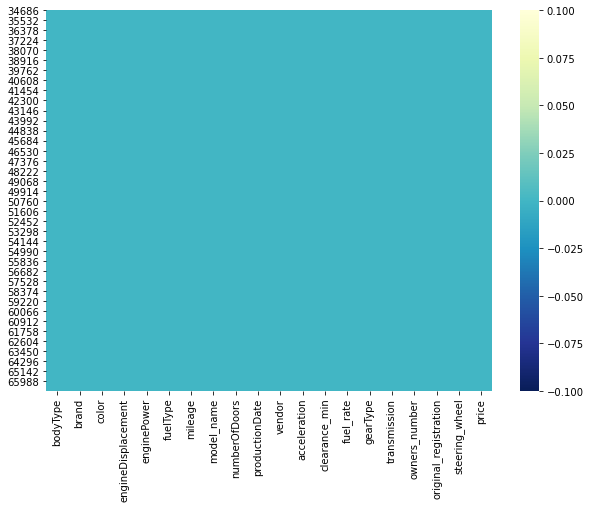

In [198]:
plt.figure(figsize=(10, 7))# размер тепловой карты
sns.heatmap(eda.isnull(), cmap="YlGnBu_r");

## Оценка распределения значений для количественных признаков, поиск и устранение ошибок/аномальных значений.

In [199]:
# Объявим словарь описаний полей, для дальнейшего использования при анализе
descriptions = {
    "bodyType": "Тип кузова",
    "brand": "Марка авто",
    "color": "Цвет автомобиля",
    "engineDisplacement": "Объем двигателя",
    "enginePower": "Мощность двигателя",
    "fuelType": "Тип топлива",
    "mileage": "Пробег",
    "model_name": "Количество Модель",
    "numberOfDoors": "Количество дверей",
    "productionDate": "Количество лет со дня выпуска",
    "vendor": "Производитель",
    "acceleration": "Разгон",
    "clearance_min": "Клиренс",
    "fuel_rate": "Поотребление топлива",
    "gearType": "Привод",
    "transmission": "Трансмиссия",
    "owners_number": "Количество владельцев",
    "original_registration": "Характеристика ПТС",
    "steering_wheel": "Расположение руля",
    "price": "Цена автомобиля"
}

## Быстрый осмотр признаков

### bodyType

Тип кузова

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


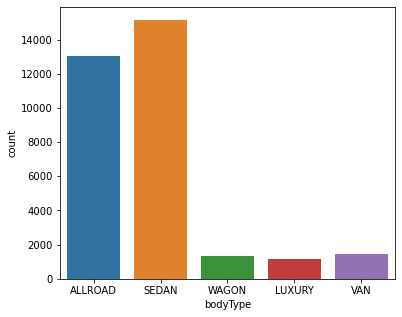

### brand

Марка авто

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


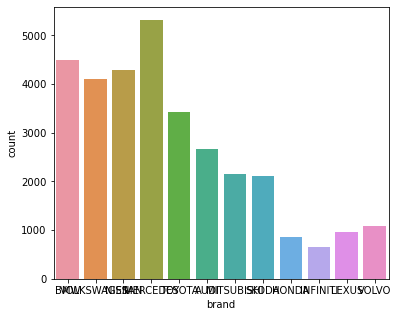

### color

Цвет автомобиля

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


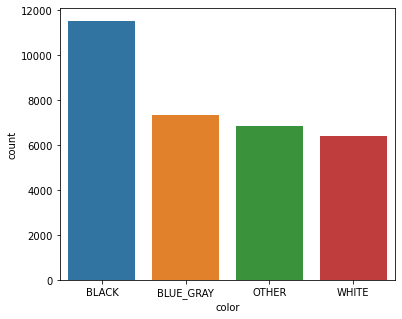

### engineDisplacement

Объем двигателя

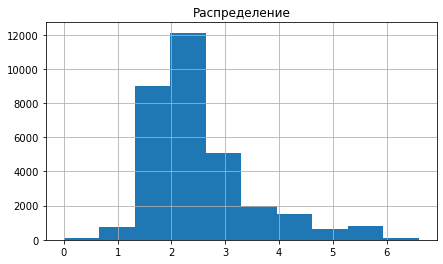

### enginePower

Мощность двигателя

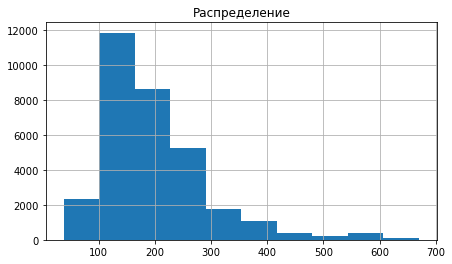

### fuelType

Тип топлива

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


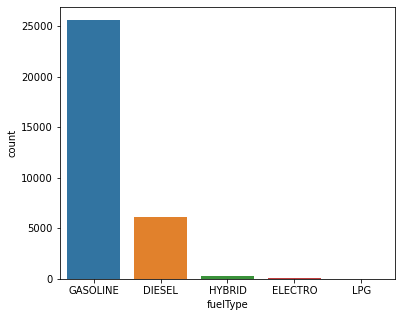

### mileage

Пробег

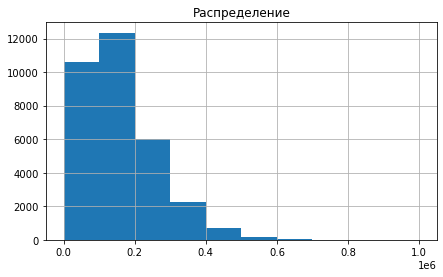

### model_name

Количество Модель

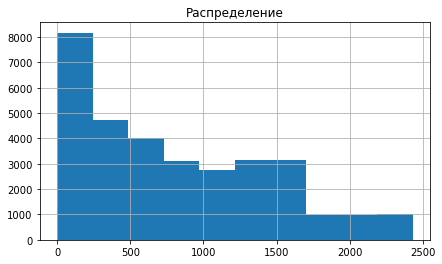

### numberOfDoors

Количество дверей

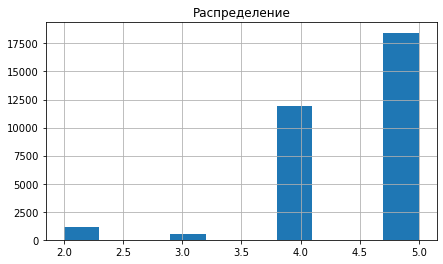

### productionDate

Количество лет со дня выпуска

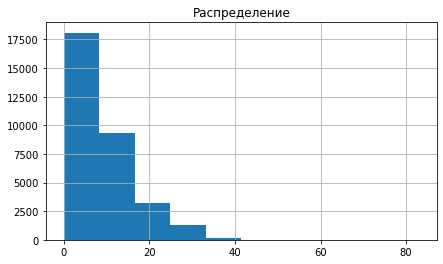

### vendor

Производитель

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


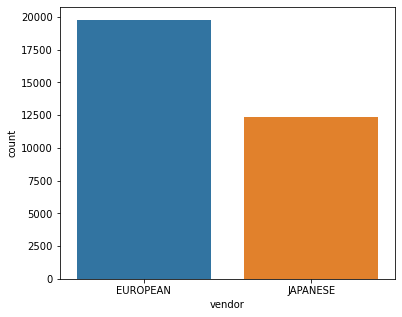

### acceleration

Разгон

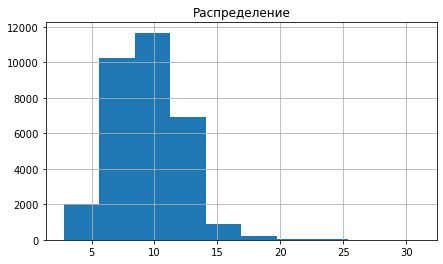

### clearance_min

Клиренс

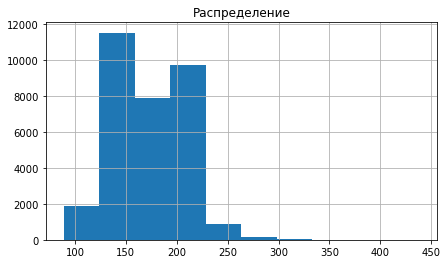

### fuel_rate

Поотребление топлива

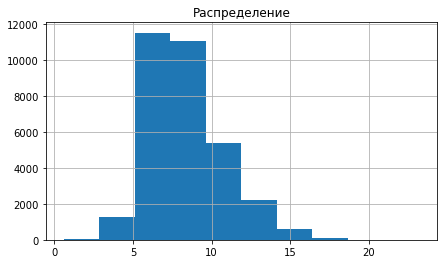

### gearType

Привод

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


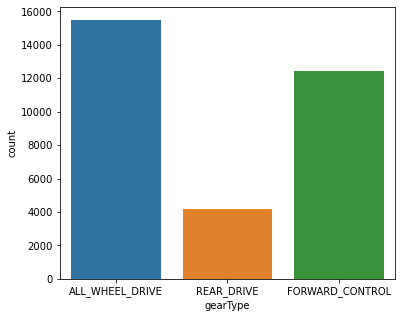

### transmission

Трансмиссия

/Users/Dima/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


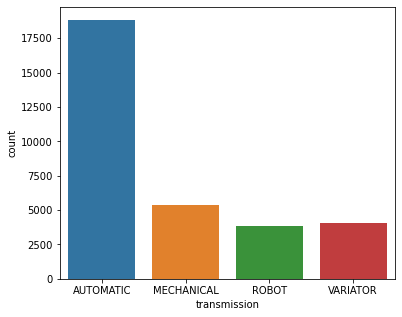

### owners_number

Количество владельцев

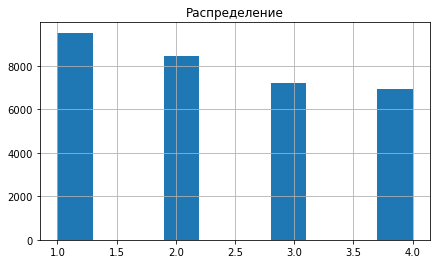

### original_registration

Характеристика ПТС

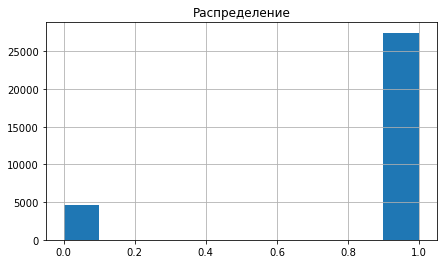

### steering_wheel

Расположение руля

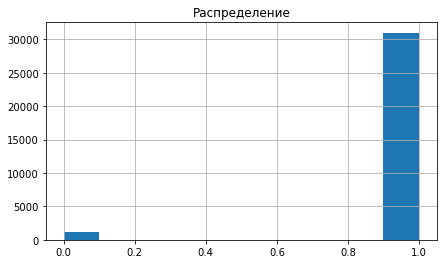

### price

Цена автомобиля

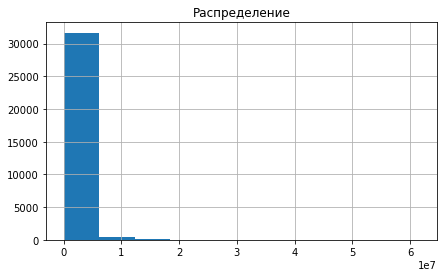

In [200]:
for col in eda.columns:
    first_look(eda, col, descriptions)

### Выводы после быстрого осмотра данных

1. По типу кузова большинство машин относится к 5-дверному типу и аналогу - седану
2. По марке авто имеем несбалансированную выборку: MERCEDES представлена в бОльшем количестве (5317), чем остальные; LEXUS, HONDA и INFINITI имееются в количестве менее 1000 шт., остальные больше 1000 шт.
3. Значительно преобладают машины с чёрным цветом. Примерно в два раза меньше машин белого цвета. Реже встречаются автомобили других цветов.
4. Объем двигателя в объявлениях сконцентрирован в промежутке от 1.5 до 3. Остальные значения более редки.
5. Признак мощности двигателя напоминает Пуассоновское распределение. Возможно, стоит прологарифмировать данный признак.
6. В датасете представлено мало автомобилей с гибридным типом топлива, электромашин, а также типа LPG. Преобладают автомобили на газу, бензине и дизеле.
7. Обычно пробег машин не превышает 400000 км, однако имеются и слишком изношенные. Возможно, стоит прологарифмировать признак, чтобы избавится от "жирого хвоста".
8. По количеству лет со дня выпуска большинство автомобилей не старше 30-40 лет, однако есть исключения до 80 лет. Возможно, стоит прологарифмировать данный признак.
9. Европейских автомобилей представлено в 1.6 раза больше, чем японских.
10. Признак "разгон" имеет вид нормального распределения, однако имеется "жирный хвост". Возможно, стоит прологарифмировать данный признак.
10. Признак "клиренс" имеет вид нормального (или бимодального?) распределения, однако имеется жирный хвост. Возможно, стоит прологарифмировать данный признак.
11. "Потребление топлива" на 100 км обычно не превышает 10 л, однако имеется "жирный хвост". Возможно, стоит прологарифмировать данный признак.
12. По типу привода большинство машин полноприводные или переднеприводные, остальные представлены реже.
13. У большинства авто трансмиссия автоматическая. 
14. Количество владельцев у представленых автомобилей не превышает 4.
15. Большинство авто имеют оригинальный ПТС.
16. Как и ожидалось, левостороннее расположение руля превалирует в выборке, однако присутствуют и правосторонние в количестве 1108, что примерно в 30 раз меньше. В этом отношении выборка сильно несбалансирована.
17. Очевидно, что цена имеет "жирный хвост" и данный признак нуждается в логарифмировании.

## Корреляционный анализ количественных признаков

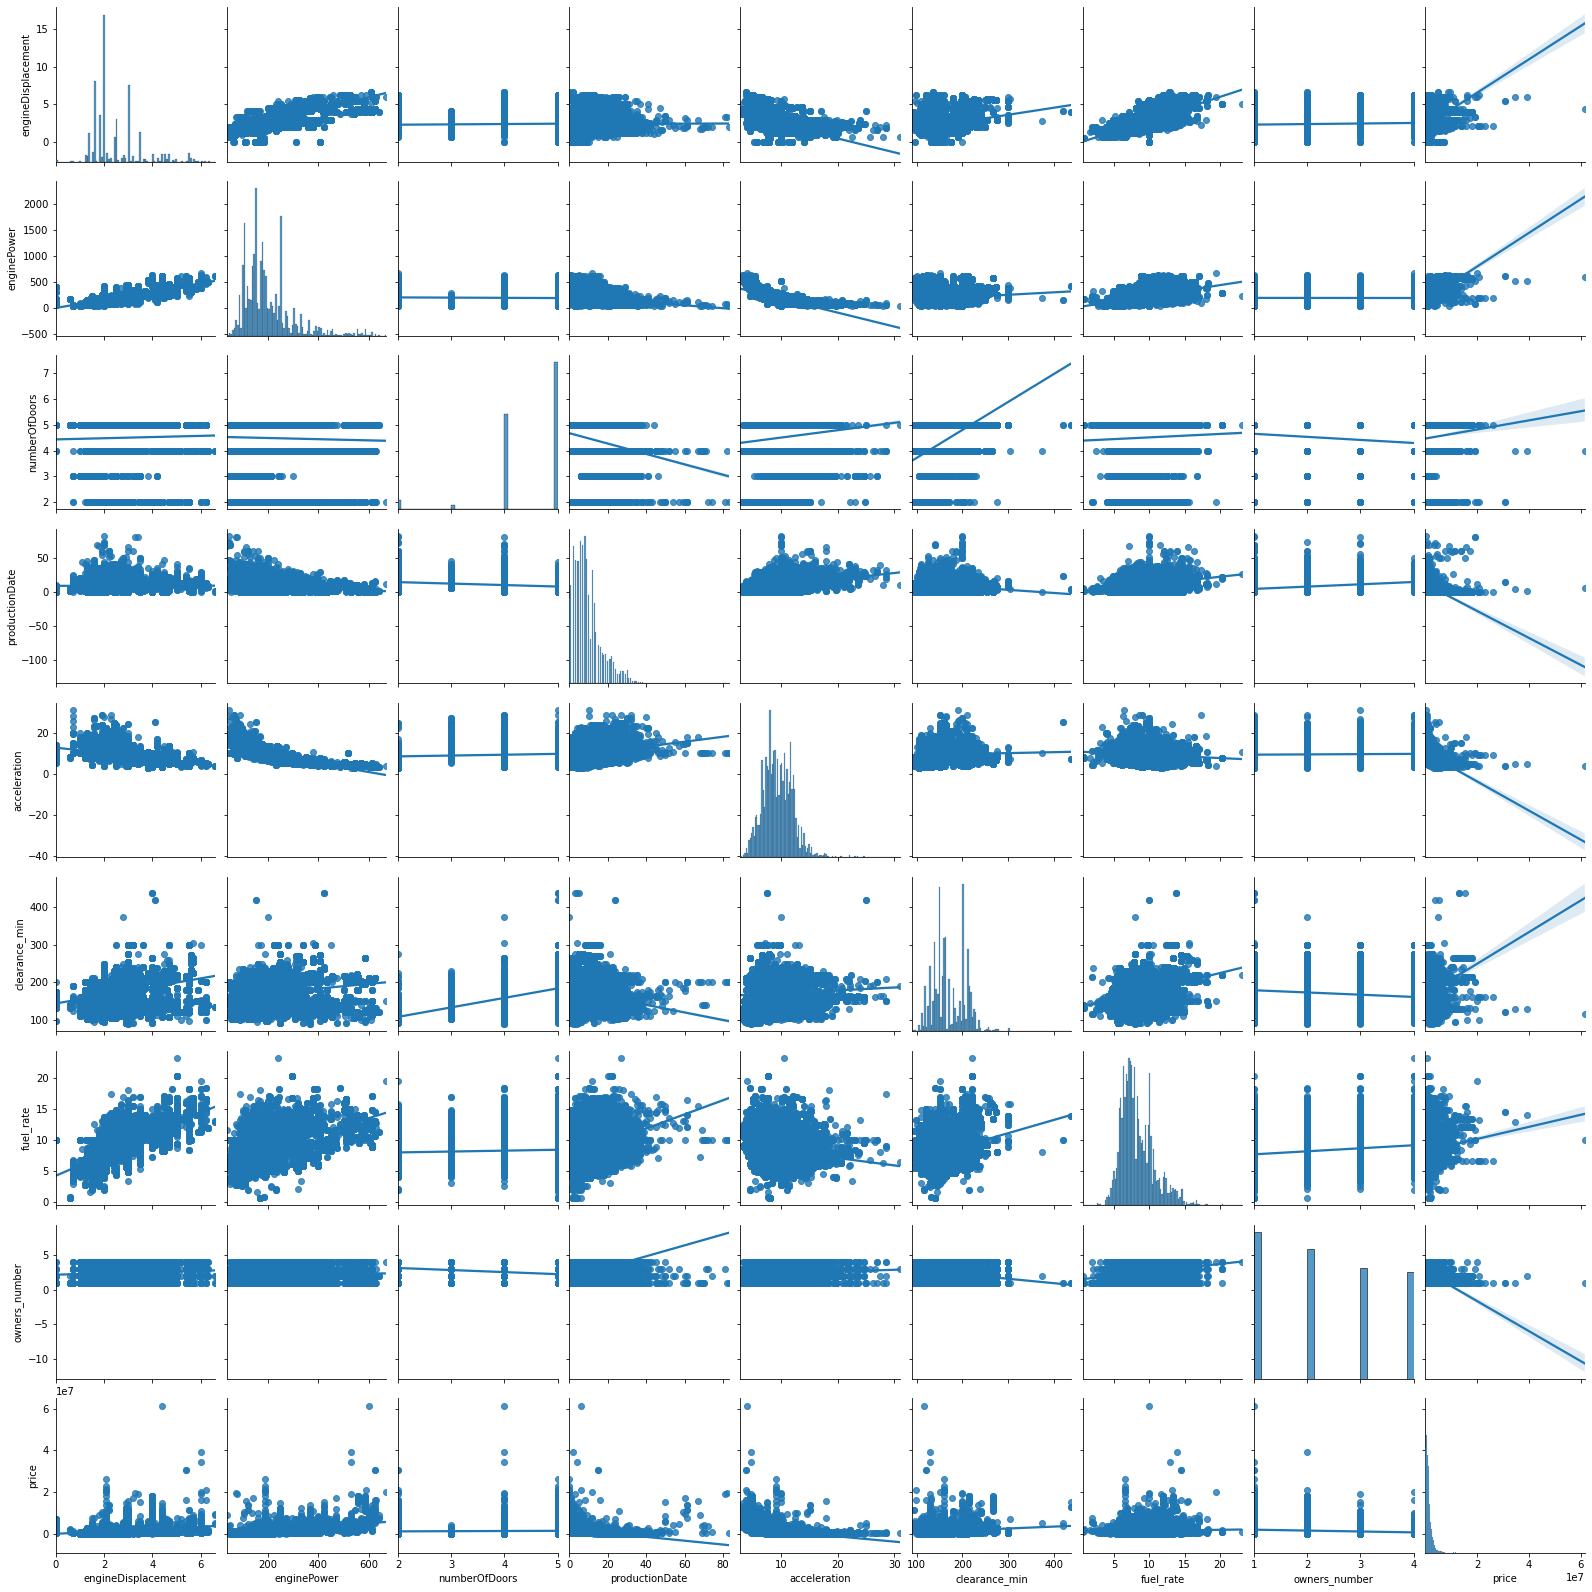

In [201]:
stud_num = ['engineDisplacement', 'enginePower', 'numberOfDoors', 'productionDate', 'acceleration',
           'clearance_min', 'fuel_rate', 'owners_number', 'price']
sns.pairplot(eda[stud_num], kind='reg');

Исходя из этих данных однозначных выводов по корреляции между данными характеристиками сделать затруднительно. Посмотрим на матрицу корреляций.

In [202]:
eda[stud_num].corr()

,engineDisplacement,enginePower,numberOfDoors,productionDate,acceleration,clearance_min,fuel_rate,owners_number,price
engineDisplacement,1.000000,0.825369,0.031811,0.004566,-0.492259,0.321779,0.715539,0.082527,0.353031
enginePower,0.825369,1.000000,-0.030589,-0.217453,-0.755105,0.170617,0.517717,-0.008728,0.543054
numberOfDoors,0.031811,-0.030589,1.000000,-0.208863,0.107244,0.521456,0.043620,-0.186217,0.039390
productionDate,0.004566,-0.217453,-0.208863,1.000000,0.332757,-0.216220,0.359513,0.516625,-0.430366
acceleration,-0.492259,-0.755105,0.107244,0.332757,1.000000,0.057987,-0.136091,0.054816,-0.420480
clearance_min,0.321779,0.170617,0.521456,-0.216220,0.057987,1.000000,0.312720,-0.193578,0.194951
fuel_rate,0.715539,0.517717,0.043620,0.359513,-0.136091,0.312720,1.000000,0.233449,0.066169
owners_number,0.082527,-0.008728,-0.186217,0.516625,0.054816,-0.193578,0.233449,1.000000,-0.305546
price,0.353031,0.543054,0.039390,-0.430366,-0.420480,0.194951,0.066169,-0.305546,1.000000


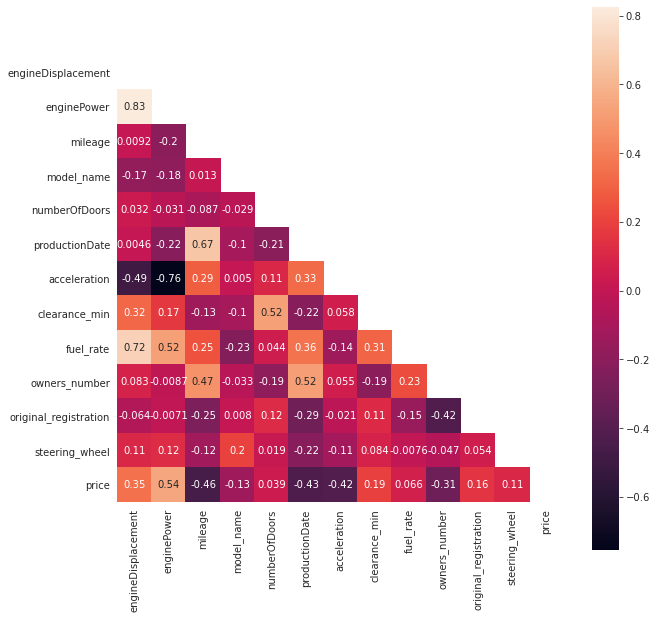

In [203]:
corr = eda.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

Сделаем отдельный датафрейм для кореллирующих значений

In [204]:
score_correlation_df = pd.DataFrame(eda.corr()["price"].values,
                                    index=eda.corr()["price"].index,
                                    columns=['correlation'])
score_correlation_df = score_correlation_df.drop("price")

score_correlation_df['corellation_amount'] = abs(
    score_correlation_df.correlation)
printmd("#### Кореллирующие значения в порядке убывания")
score_correlation_df.sort_values(by='corellation_amount', ascending=False)

#### Кореллирующие значения в порядке убывания

,correlation,corellation_amount
enginePower,0.543054,0.543054
mileage,-0.459823,0.459823
productionDate,-0.430366,0.430366
acceleration,-0.420480,0.420480
engineDisplacement,0.353031,0.353031
owners_number,-0.305546,0.305546
clearance_min,0.194951,0.194951
original_registration,0.157863,0.157863
model_name,-0.126436,0.126436
steering_wheel,0.106885,0.106885


### Выводы по результатам корреляционного анализа:
1. Сильно скоррелированных признаков (0.9 и более) не представлено
2. Наибольшая связь представлена между признаками "Объем двигателя", "Мощность двигателя" и "Потребление топлива", что логично.
3. Присутствует заметная отрицательная корреляция между "Разгоном" и ("Объем двигателя", "Мощность двигателя")
4. Касательно связи признаков с целевой переменной (ценой), то все признаки, за исключением "Количества дверей" и "Потреблением топлива" имеет выраженную корреляцию, как положительную, так и отрицательную.

Проверим отдельно признак "Количестов дверей" со слабой коррелицией к целевой переменной:

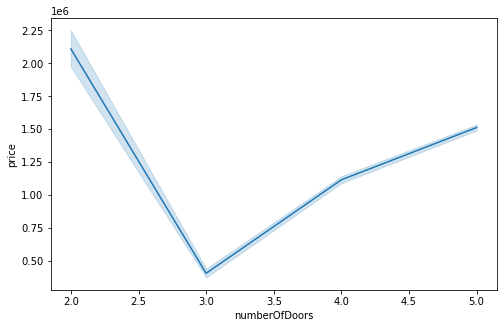

In [205]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=eda, x='numberOfDoors', y='price');

Видно, что нелинейная связь присутствует. => признак стоит оставить.

## Визуальный анализ номинативных признаков, оценка количества уникальных значений.

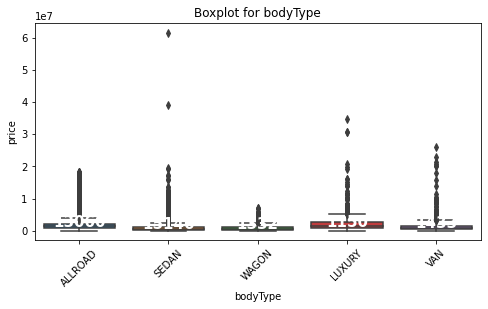

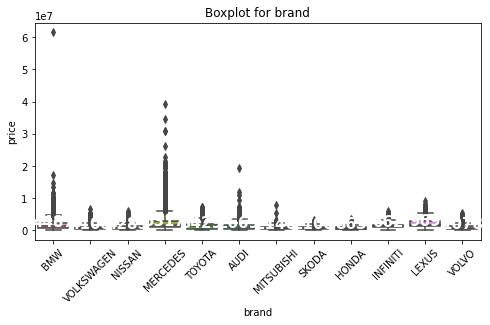

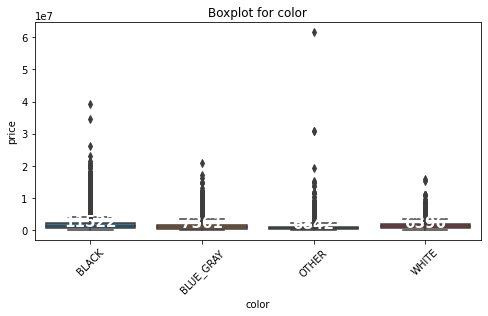

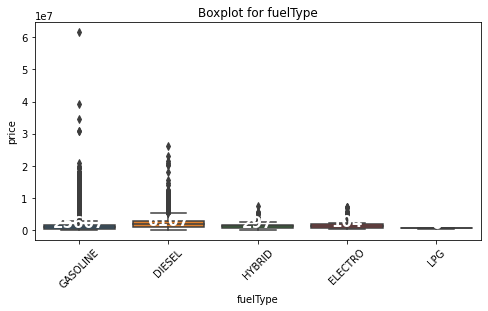

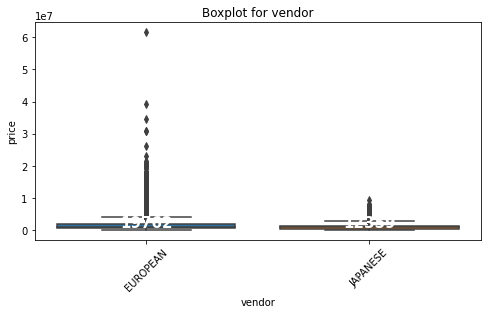

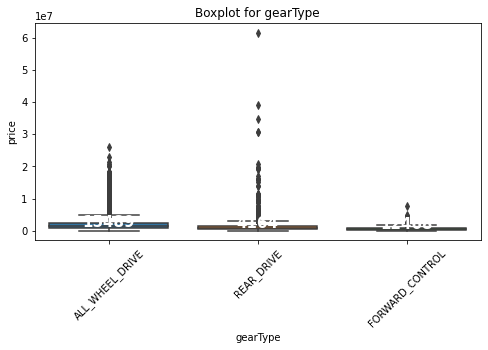

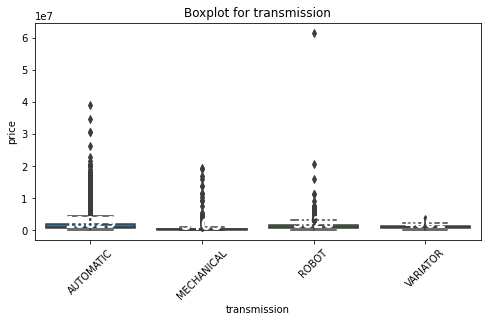

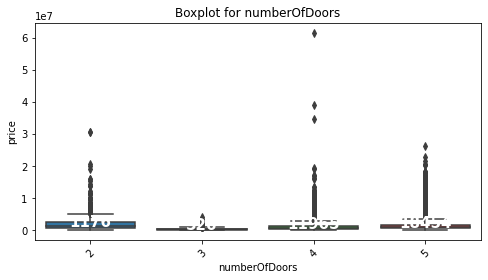

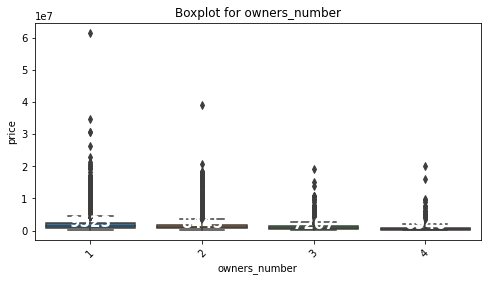

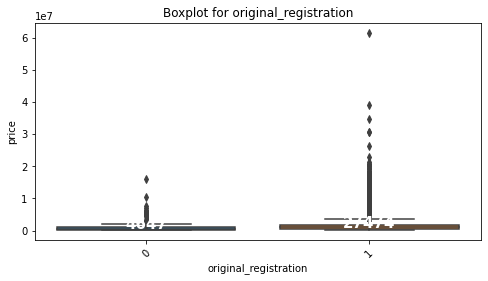

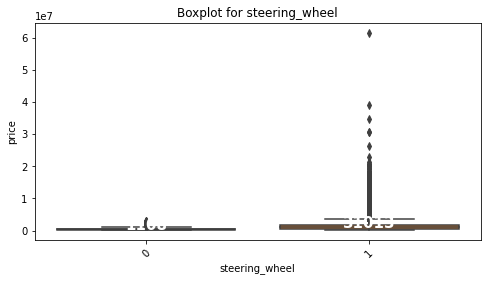

In [206]:
nom_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vendor', 'gearType',
            'transmission', 'numberOfDoors', 'owners_number', 'original_registration', 'steering_wheel']
for col in nom_cols:
    get_boxplot(eda, col)

=> Анализ номинативных признаков затруднён из-за присутствия очень дорогих авто. => Прологарифмируем цену.

In [207]:
eda['price2'] = eda['price'].apply(lambda x: np.log(x))

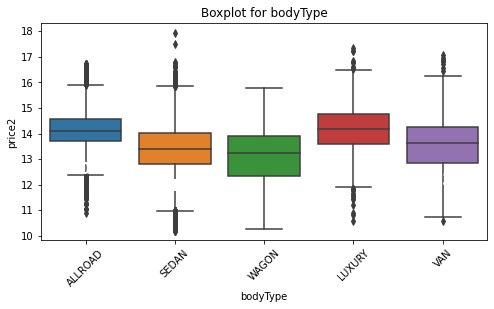

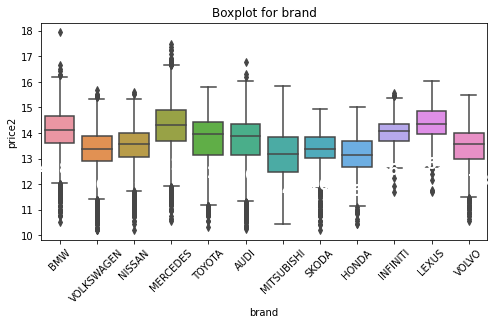

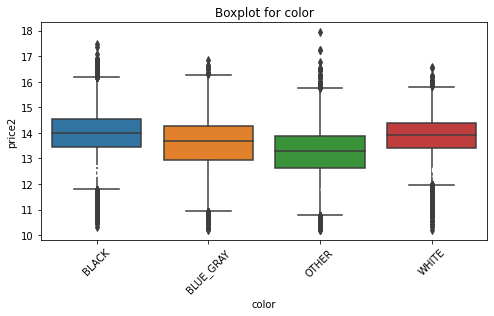

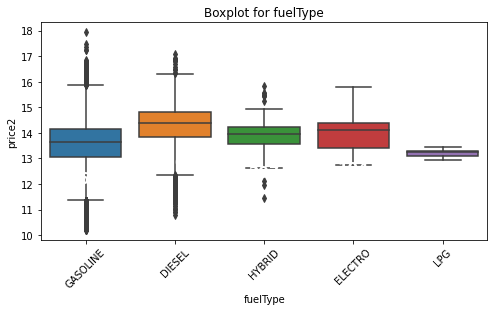

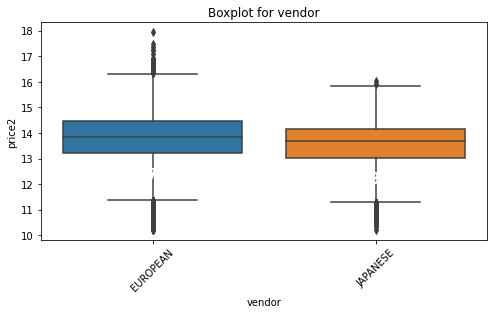

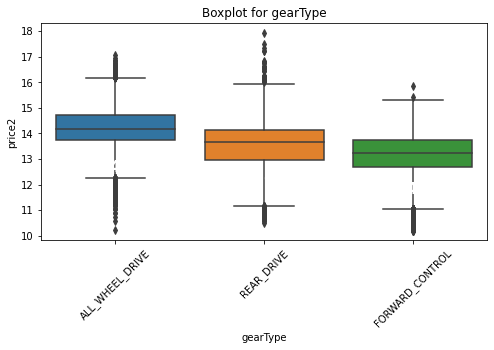

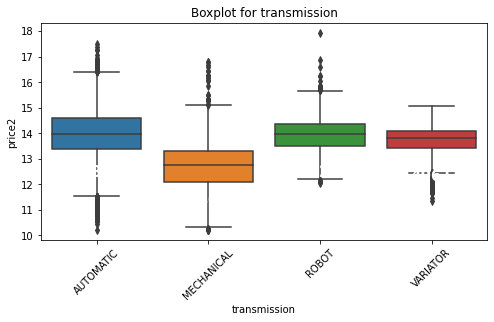

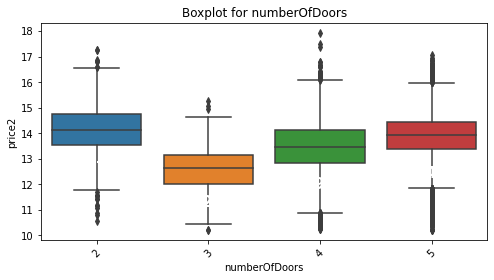

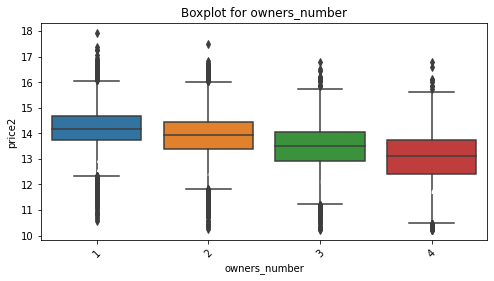

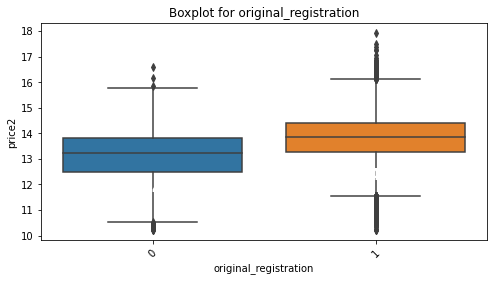

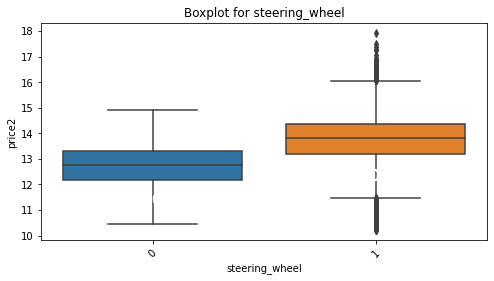

In [208]:
nom_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vendor', 'gearType',
            'transmission', 'numberOfDoors', 'owners_number', 'original_registration', 'steering_wheel']
for col in nom_cols:
    get_boxplot(eda, col, ax_y='price2')

### Вывод:
1. Обычно наиболее дорогие авто - авто класса "LUXURY", что отражает это название (логично). Самые бюджетными классами являются "WAGON" и "HATCHBACK". Но это разделение не носит ярковыраженного характера.
2. Тройка дорогих марок - BMW, MERCEDES и LEXUS. Бюджетные - VOLKSWAGEN и HONDA.
3. Предсказуемо чёрные авто обычно самые дорогие, но также и белые недалеко по медианной цене. Последнее удивило.
4. Автомобили на дизиле как правило более дорогие.
5. За японские машины обычно просят меньшую цену.
6. Полноприводные автомобили как правило имеют более высокую цену, в сравнении с другими.
7. Машины с механической коробкой передач заметно дешевле других типов.
8. Авто с 3 дверьми стоят недорого по сравнению с другими вариантами. Интересно, что двухдверные машины обычно имеют самую высокую цену. Скорее всего, двухдверные авто являются спорткарами или им подобными.
9. Цена авто обратнозависима от количества владельцев, что логично.
10. Машины с отсутствием оригинального ПТС заметно дешевле.
11. Расположение руля также вносит серьёзный вклад в цену. Левостороннее расположение как правило дороже.

## t-test номинативных и смешанных переменных

С помощью теста Стьюдента проверим есть ли статистическая разница в распределении оценок по номинативным признакам, проверив нулевую гипотезу о том, что распределение цены автомобиля в зависимости от уровней категорий неразличимы

In [209]:
lst = []
for col in nom_cols:
    if get_stat_dif(eda, col):
        lst.append(col)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки vendor
Найдены статистически значимые различия для колонки gearType
Найдены статистически значимые различия для колонки transmission
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки owners_number
Найдены статистически значимые различия для колонки original_registration
Найдены статистически значимые различия для колонки steering_wheel


# ML

Готовим данные для обучения

In [210]:
RANDOM_SEED = 42

In [211]:
cat_cols_df = data[['bodyType','fuelType', 'gearType','brand','transmission']]

In [212]:
cat_cols_df_dummies = pd.get_dummies(cat_cols_df)

In [213]:
data = data.join(cat_cols_df_dummies)

In [214]:
data.drop(['bodyType','brand', 'fuelType','gearType', 'transmission','vendor','color',\
          'model_name','fuelType_DIESEL'],inplace = True, axis = 1)

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   engineDisplacement        66807 non-null  float64
 1   enginePower               66807 non-null  int64  
 2   mileage                   66807 non-null  int64  
 3   numberOfDoors             66807 non-null  int64  
 4   productionDate            66807 non-null  int64  
 5   sell_id                   66807 non-null  int64  
 6   acceleration              66807 non-null  float64
 7   clearance_min             66807 non-null  float64
 8   fuel_rate                 66807 non-null  float64
 9   owners_number             66807 non-null  int64  
 10  original_registration     66807 non-null  int64  
 11  steering_wheel            66807 non-null  int64  
 12  sample                    66807 non-null  int64  
 13  price                     66807 non-null  int64  
 14  bodyTy

In [216]:
# разделение данных для обучения и теста
train = data.query('sample == 1').drop(['sample', 'sell_id'], axis=1)
X_train = train.drop('price',axis = 1)
y_train = train['price']

In [217]:
test = data.query('sample == 0')
sell_id = test[['sell_id']]
test = test.drop(['sample', 'sell_id','price'], axis=1)
X_test = test

In [218]:
# разделим данные для валидации и обучения

In [219]:
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train,y_train, test_size=0.15,\
                                                      shuffle=True, random_state=RANDOM_SEED)

In [220]:
# Функция для расчета метрики "вручную"
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## LinearRegression

In [221]:
reg = LinearRegression().fit(X_train_v, y_train_v)

y_pred = reg.predict(X_val)
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 87.23%


## DecisionTreeRegressor

In [222]:
dtr = DecisionTreeRegressor(random_state=42)

dtr.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(dtr.predict(X_val))

print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 19.98%


## BaggingRegressor

In [223]:
dtr = DecisionTreeRegressor(random_state=42)

bagging_trees = BaggingRegressor(dtr)

bagging_trees.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(bagging_trees.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 14.71%


## RandomForestRegressor

In [224]:
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(rfr.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 14.16%


## AdaBoostRegressor

In [225]:
regr = AdaBoostRegressor(random_state=42, n_estimators=1000)
regr.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(regr.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 33.32%


## GradientBoostingRegressor

In [226]:
gb = GradientBoostingRegressor(random_state=42,
                               min_samples_split=2, 
                               learning_rate=0.1, 
                               max_depth=7,
                               n_estimators=500)

gb.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(gb.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.91%


## CatBoostRegressor

In [232]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          custom_metric=['R2', 'MAE'],
                          silent=True,)
model.fit(X_train_v, np.log(y_train_v))
y_pred = np.exp(model.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.84%


## LGBMRegressor

In [233]:
# В виду сложности установки модуля данной модели на локальный компьютер, расчёт проводился на kaggle.
# Результат сопоставим c CatBoost

# lgbmr = LGBMRegressor(random_state=RANDOM_SEED,
#                             max_depth=14,
#                             n_estimators=800)

# lgbmr.fit(X_train, np.log(y_train))
# y_pred = np.exp(lgbmr.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_val,y_pred))*100:0.2f}%")

## Стэкинг

Было перепробовано множество вариаций стекинга, представленных выше моделей, но по всей видимости из-за того, что большинство моделей (за исключением линейной регрессии) одной природы, т.е. построены на деревьях, они не выдают результат лучше, чем отдельные модели. Сама же линейная регрессия выдаёт очень плохой результат. Соответственно, её наличие в базисных моделях ни к чему хорошему не приводит.

Ниже представлены два разных подхода к стекингу: с использованием импорта специального класса из sklearn и без.

In [234]:
# # Стекинг с использованием класса StackingRegressor
# #from sklearn.ensemble import StackingRegressor

# estimators = [('xgbr', XGBRegressor(random_state=RANDOM_SEED,
#                             max_depth=12,
#                             n_estimators=1000,
#                             learning_rate=0.03,
#                             objective='reg:squarederror',
#                             colsample_bytree=0.5,
#                             alpha=1)),
#               ('lgbmr', LGBMRegressor(random_state=RANDOM_SEED,
#                             max_depth=14,
#                             n_estimators=800)),
#               ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                    max_depth=5,
#                                    n_estimators=1000))
# ]

# reg = StackingRegressor(estimators=estimators,
#                         passthrough=True)
# reg.fit(X_train, np.log(y_train))

# y_pred = np.exp(reg.predict(X_val))
# predict_submission = np.exp(reg.predict(X_test))

# print(f"Точность модели по метрике MAPE: {(mape(y_val, y_pred))*100:0.2f}%")

In [235]:
# # Без использования класса StackingRegressor

# # get a list of base models
# def get_models():
#     models = list()
#     models.append(('rfr', CatBoostRegressor()))
#     models.append(('dtr', RandomForestRegressor()))
#     models.append(('etr', ExtraTreesRegressor()))
#     models.append(('gbr', GradientBoostingRegressor()))
#     models.append(('dtr', DecisionTreeRegressor()))
#     return models

# models = get_models()

# # fit all models on the training set and predict on hold out set
# meta_X = list()
# for name, model in tqdm(models):
#     # fit in training set
#     model.fit(X_train_v, y_train_v)
#     # predict on hold out set
#     yhat = model.predict(X_val)
#     # reshape predictions into a matrix with one column
#     yhat = yhat.reshape(len(yhat), 1)
#     # store predictions as input for blending
#     meta_X.append(yhat)
    
# # create 2d array from predictions, each set is an input feature
# meta_X = np.hstack(meta_X)

# # define blending model
# blender = DecisionTreeRegressor()
# # fit on predictions from base models
# blender.fit(meta_X, y_val)

# # make a prediction with the blending ensemble
# def predict_ensemble(models, blender, X_val):
#     # make predictions with base models
#     meta_X = list()
#     for name, model in models:
#         # predict with base model
#         yhat = model.predict(X_val)
#         # reshape predictions into a matrix with one column
#         yhat = yhat.reshape(len(yhat), 1)
#         # store prediction
#         meta_X.append(yhat)
#         # create 2d array from predictions, each set is an input feature
#         meta_X = np.hstack(meta_X)
#         # predict
#     return blender.predict(meta_X)

# score = mean_absolute_percentage_error(y_val, yhat)
# print('Blending MAPE: %.3f' % score)

## Подбор параметров для моделей
Для моделей проводился подбор наилучших параметров по сетке GridSearchCV. К сожалению, данный способ занимал слишком много времени и самое неприятное то, что он не привнёс положительных результатов. Гораздо быстрее и эффективнее был ручной перебор параметров для всех моделей. Также использовалась optuna для подбора параметров, но и в этом случае результат приходилоьс ждать слишком долго и эффект был скорее отрицательным. Ниже представлен код перебора параметров по сетке GridSearchCV с использованием небольшого числа узлов сетки на примере модели GradientBoostingRegressor. Другие модели при подборе параметров также не продемонстрировали удовлетворительного результата.

In [236]:
# def regularise(X_train, y_train):
#     max_depth = [5, 7, 10]
#     n_estimators = [600, 800, 1000]
#     learning_rate = [0.01, 0.1]
#     hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
#     model = GradientBoostingRegressor()
#     model.fit(X_train, y_train)

#     clf = GridSearchCV(model, hyperparameters)

#     best_model = clf.fit(X_train, y_train)

#     best_max_depth = best_model.best_estimator_.get_params()['max_depth']
#     best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']
#     best_learning_rate = best_model.best_estimator_.get_params()['learning_rate']

#     return best_max_depth, best_n_estimators, best_learning_rate

# best_max_depth, best_n_estimators, best_learning_rate = regularise(X_train, y_train)
# best_max_depth, best_n_estimators, best_learning_rate

## submission

In [237]:
model = CatBoostRegressor(iterations = 5000,
                          random_state=42,
                          custom_metric=['R2', 'MAE'],
                          silent=True)

model.fit(X_train, np.log(y_train))
y_pred = np.exp(model.predict(X_test))

In [238]:
submission = pd.concat([sell_id.sell_id,pd.Series(y_pred,name='price')],axis=1)
submission.to_csv('My_sub_CB.csv', index=False)

## Выводы:
1. Собраны и предварительно проанализированы данные с сайта  auto.ru, для марок представленных в тесте и с годом выпуска до 2020, как и тестовая выборка(смотреть файл Парсер Auto-ru.ipynb);

2. Собранные и тестовые данные одинаково предобработаны;

3. Проведен разведовательный анализ обработанных данных (EDA), по результатам которого было выявлено, что практически все признаки являются значимыми (подробнее в разделе EDA);

4. В процессе обучения моделей протестированы различные комбинации признаков: 
- Опытным путем было выявлено, что признак color никак не влияет на целевую переменную, также как и признак vendor.
- Удаление сильно коррелирующих признаков ухудшало метрику.
- Не удалось достаточно обработать признак model_name, так как в данных было более 500 различных моделей, сделать из этого признака dummie переменную практически невозможно, были попытки разделить все марки в зависимости от цены на 4 категории, что привело к ухудшению метрики, так как была задействована целевая переменная в создании такого признака. В итоге единственным логичным вариантом стало заменить данные в столбце на количество моделей в выборке.
- Предпринимались попытки сократить количество уникальных значений в столбце brand, но также разделение машин на классы ухудшило метрику и лучшим вариантом для данного столбца оказались dummie значения из всех уникальных значений. 
- Столбец bodyType наоборот показал лучшее влияние на целевую переменную после сокращения уникальных значений
- Пробовали заменить год в столбце prodactionDate на разницу между годом сбора данных и фактическим, что казалось достаточно логичным решением, но такие действия ухудшили метрику, и оптимальным вариантом оказалось отнимать фактический год производства от 2020 года. 
- Столбец equipment_dict содержал много полезной информации, но к сожалению присуствовало очень много пропусков, и все попытки как-то использовать его данные привели к ухудшению метрики => приняли решение отказаться от данного признака.

5. Машинное обучение (ML) проводилось с применением широкого ряда моделей:

- LinearRegression показала наихудший результат на валидации и значение метрики немного улучшилось только после уменьшения размерности итоговой таблицы и удаления сильно кореллирующих признаков, но ниже 75% не удалось получить по этой модели.

- DecisionTreeRegressor показала на базавовых параметрах довольно неплохой результат, в районе 20%, но этого не достаточно для точного предсказания. Один из плюсов данной модели скорость ее обучения.

- BaggingRegressor показал конкурентную метрикув в райне 20% на валидации, сравнимую с различными бустингами, но в борьбе за цифры после запятой всё же уступает данная модель более прогресивным. Обучение также роходит быстро.

- RandomForestRegressor одна из лучших моделей для данной задачи, метрика на валидации всегда была около 14% и достаточно быстрое обучение.

- AdaBoostRegressor самая разочаровывоющая модель, лучший результат около 35% на валидации, причем до применения логарифмирования результат был около 500%. Считает быстро, но результаты совсем плохие.

- GradientBoostingRegressor просчитывает модель достаточно четко, в районе 14% на валидации получали результат, но на тесте результат сильно падал, разница была около 3-4% в засисимости от комбинации признаков. Очень долго проходит обучение.

- CatBoostRegressor оказался лучшим регрессором для нашей задачи, результат на валидации было ниже 14% и на тесте в районе 14-16, разрыв минимальный между валидациец и тестом, что навело на мысль что модель не переучивается и выявляет действительно тонкие взаимосвязи между данными. Модель работает довольно быстро, около 4 сек происходит обучение на нашем трейне.

- LGBMRegressor как и предыдущая модель эта тоже показывает очень хорошие результаты, но из-за сложностей в установке на стандартный юпитер ноутбук, отказались от этой модели, но сделалаи для себя выводы на будущее, что ее стоит рассматривать.

- Разнообразный стекинг не показал улучшений по целевой метрике, скорее всего из-за того, что использовались приемущественно модели одной природы, основанные на деревьях решений. 

6. Наилучший результат по метрике MAPE (14.67510) на тестовой выборке показывает модель CatBoostRegressor с параметрами (iterations = 5000,random_state=42, custom_metric=['R2', 'MAE'],silent=True);

7. Итоговое место на kaggle.com - 73.